In [1]:
!pip install pylibjpeg
!pip install pydicom
!pip install keras-cv-attention-models
!pip install dicomsdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.8/656.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 41.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.1 MB/s eta 0:00:00


In [2]:
exit()

In [2]:
import os
from glob import glob

import numpy as np
import pandas as pd

import cv2
import dicomsdl
import tensorflow as tf
from keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
glob("*")

['vis.ipynb',
 'train',
 'test',
 'valid',
 'attention_model.ipynb',
 'cnn_model.ipynb']

In [4]:
# Tensorflow and CV2 set number of threads to 1 for speedup in parallell function mapping
tf.config.threading.set_inter_op_parallelism_threads(num_threads=1)
cv2.setNumThreads(1)

TARGET_HEIGHT = 1344
TARGET_WIDTH = 768
HEIGHT_WIDTH_RATIO = TARGET_HEIGHT / TARGET_WIDTH

CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))

CROP_IMAGE = True
APPLY_CLAHE = False
APPLY_EQ_HIST = False

IMAGE_FORMAT = 'png'

In [5]:
def dcm_file_process(input_img, dicom_data):
    # Si 'WindowWidth' o 'WindowCenter' no existen en la información de los datos de píxeles, regresa la imagen original
    if 'WindowWidth' not in dicom_data.getPixelDataInfo() or 'WindowCenter' not in dicom_data.getPixelDataInfo():
        return input_img
    
    # Cargamos solo las variables que necesitamos
    lut_center = dicom_data['WindowCenter'] # Centro de la LUT
    lut_width = dicom_data['WindowWidth'] # Ancho de la LUT
    stored_bits = dicom_data['BitsStored'] # Bits almacenados
    lut_function = dicom_data['VOILUTFunction'] # Función de la LUT

    # Para la función sigmoide, se utiliza una lista, en otro caso se utiliza un solo valor
    if isinstance(lut_center, list):
        lut_center = lut_center[0]
    if isinstance(lut_width, list):
        lut_width = lut_width[0]

    # Establecemos el valor mínimo y máximo de los píxeles, así como el rango de estos
    min_pixel_val = 0
    max_pixel_val = float(2**stored_bits - 1)
    pixel_range = max_pixel_val

    if lut_function == 'SIGMOID':
        input_img = pixel_range / (1 + np.exp(-4 * (input_img - lut_center) / lut_width)) + min_pixel_val
    else:
        # Se chequea si lut_width es < 1 (en nuestro caso no es necesario, siempre es >= 750)
        lut_center -= 0.5
        lut_width -= 1

        # Se definen tres condiciones: valores por debajo, por encima y entre el centro
        lower_than_center = input_img <= (lut_center - lut_width / 2)
        higher_than_center = input_img > (lut_center + lut_width / 2)
        in_between = np.logical_and(~lower_than_center, ~higher_than_center)

        # Se asignan los valores mínimos y máximos a los píxeles correspondientes, y se aplica la función LINEAR a los que están entre
        input_img[lower_than_center] = min_pixel_val
        input_img[higher_than_center] = max_pixel_val
        if in_between.any():
            input_img[in_between] = (
                ((input_img[in_between] - lut_center) / lut_width + 0.5) * pixel_range + min_pixel_val
            )

    # Devuelve la imagen procesada
    return input_img

In [6]:
def smooth_img(kl):
    size_l = int(len(kl) * 0.01)
    kernel = np.ones(size_l) / size_l
    return np.convolve(kl, kernel, mode='same')

def x_offsets(input_img, ratio=0.05):
    H, W = input_img.shape
    margin = int(input_img.shape[1] * 0.00)
    vv = smooth_img(input_img.sum(axis=0).squeeze()) * smooth_img(input_img.std(axis=0).squeeze())
    vv_argmax = vv[:int(input_img.shape[1] * 0.75)].argmax()
    vv_threshold = vv.max() * ratio
    
    for offset, v in enumerate(vv):
        if offset < vv_argmax:
            continue
        
        if v < vv_threshold:
            offset = min(W, offset + margin)
            break
        
    return offset

def y_offsets(input_img, ratio=0.10, debug_ax=None, pred=None):
    H, W = input_img.shape
    margin = 0
    vv = smooth_img(input_img.sum(axis=1).squeeze()) * smooth_img(input_img.std(axis=1).squeeze());pred=0.875
    argmax = int(input_img.shape[0] * 0.25) + vv[int(input_img.shape[0] * 0.25):int(input_img.shape[0] * 0.75)].argmax()
    vv_threshold = vv.max() * ratio
    offset_bottom = 0
    offset_top = H

    for offset in reversed(range(0, argmax)):
        v = vv[offset]
        if v < vv_threshold:
            offset_bottom = offset
            break
            
    for offset in range(argmax, H):
        v = vv[offset]
        if v < vv_threshold:
            offset_top = offset
            break
            
    if isinstance(debug_ax, np.ndarray):
        debug_ax[2].imshow(input_img)
        debug_ax[2].set_title('tumor detection')
        scale = W / vv.max() * 0.90
        debug_ax[2].plot(vv * scale, np.arange(H) , c='red', label='density')
        debug_ax[2].scatter(vv[argmax] * scale, argmax, c='blue', s=100, label='tumor', zorder=np.PINF)
        debug_ax[2].annotate(f"{round(pred, 4)}", (vv[argmax] * scale, argmax), textcoords="offset points", xytext=(0,10), ha='center')  # línea añadida
        debug_ax[2].set_ylim(H, 0)
        debug_ax[2].legend()
        debug_ax[2].axis('off')
            
    return max(0, offset_bottom - margin), min(input_img.shape[0], offset_top + margin)

# Crop image and pad offsets to target image height/width ratio to preserve information
def crop_img(input_img, size=None, debug=False, model=None):
    # input_Img dimensions
    H, W = input_img.shape

    if model is not None:
        pred = model.predict(input_img.reshape(-1, 1))[0]
    # Compute x/bottom/top offsets
    x_offset = x_offsets(input_img)
    offset_bottom, offset_top = y_offsets(input_img[:,:x_offset], debug_ax=debug)
    # Crop Height and Width
    h_crop = offset_top - offset_bottom
    w_crop = x_offset
    
    # Pad crop offsets to target aspect ratio
    if size is not None:
        # Height too large, pad x offset
        if (h_crop / w_crop) > HEIGHT_WIDTH_RATIO:
            x_offset += int(h_crop / HEIGHT_WIDTH_RATIO - w_crop)
        else:
            # Height too small, pad bottom/top offsets
            offset_bottom -= int(0.50 * (w_crop * HEIGHT_WIDTH_RATIO - h_crop))
            offset_bottom_correction = max(0, -offset_bottom)
            offset_bottom += offset_bottom_correction

            offset_top += int(0.50 * (w_crop * HEIGHT_WIDTH_RATIO - h_crop))
            offset_top += offset_bottom_correction
        
    # Crop input_Img
    input_img = input_img[offset_bottom:offset_top:,:x_offset]
        
    return input_img

In [7]:
def dcm_inference(file_path, size=(TARGET_WIDTH, TARGET_HEIGHT), model=None, crop_image=CROP_IMAGE, apply_clahe=APPLY_CLAHE, apply_eq_hist=APPLY_EQ_HIST, debug=False, save=True):
    # Read Dicom File
    dicom = dicomsdl.open(file_path)
    image_m = dicom.pixelData()
    
    if debug:
        fig, axes = plt.subplots(3, 1, figsize=(30,20))
        image0 = np.copy(image_m)
        axes[0].imshow(image0)
        axes[0].set_title('Original')
        axes[0].axis('off')
    else:
        axes = False
    
    try:
        image_m = dcm_file_process(input_img=image_m, dicom_data=dicom)
    except:
        pass
    
    if dicom.getPixelDataInfo()['PhotometricInterpretation'] == 'MONOCHROME1':
        image_m = np.max(image_m) - image_m

    # Normalize [0,1] range
    image_m = (image_m - image_m.min()) / (image_m.max() - image_m.min())

    # Convert to uint8 image in range [0, 255]
    image_m = (image_m * 255).astype(np.uint8)
    
    # Flip T0 Left/Right Orientation
    h0, w0 = image_m.shape
    if image_m[:,int(-w0 * 0.10):].sum() > image_m[:,:int(w0 * 0.10)].sum():
        image_m = np.flip(image_m, axis=1)
    
    # Crop image
    if crop_image:
        image_m = crop_img(image_m, debug=axes, model=model)
        
    # Resize
    if size is not None:
        # Pad black pixels to make square image
        h, w = image_m.shape
        if (h / w) > HEIGHT_WIDTH_RATIO:
            pad = int(h / HEIGHT_WIDTH_RATIO - w)
            image_m = np.pad(image_m, [[0,0], [0, pad]])
            h, w = image_m.shape
        else:
            pad = int(0.50 * (w * HEIGHT_WIDTH_RATIO - h))
            image_m = np.pad(image_m, [[pad, pad], [0,0]])
            h, w = image_m.shape
        # Resize
        image_m = cv2.resize(image_m, size, interpolation=cv2.INTER_AREA)
        
    # Apply CLAHE contrast enhancement
    if apply_clahe:
        image_m = CLAHE.apply(image_m)
        
     # Apply Histogram Equalization
    if apply_eq_hist:
        image_m = cv2.equalizeHist(image_m)
        
    # Show Processed Image    
    if debug:
        axes[1].imshow(image_m)
        axes[1].set_title('Processed Image')
        axes[1].axis('off')
        plt.show()
        
    # Save Only
    if save:
        image_id = file_path.split('/')[-1].split('.')[0]
        if IMAGE_FORMAT == 'png':
            cv2.imwrite(f'{image_id}.png', image_m)
        else:
            cv2.imwrite(f'{image_id}.jpg', image_m, [cv2.IMWRITE_JPEG_QUALITY, 95])

In [8]:
glob("tr*/*")

['train/cancer', 'train/noCancer']

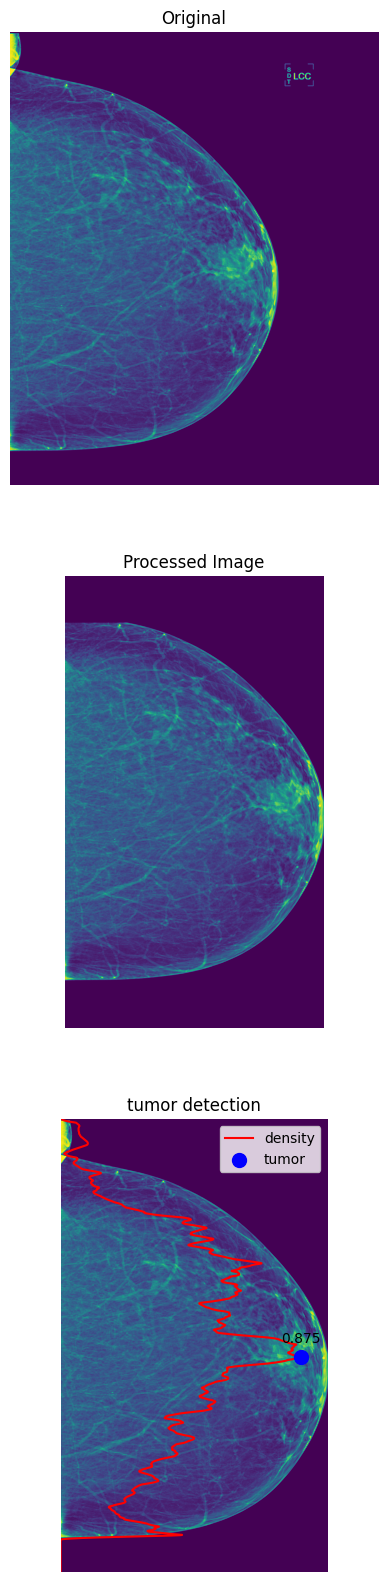

In [9]:
fp = 'train/cancer/1.dcm'

dcm_inference(fp, crop_image=True, size=(TARGET_WIDTH, TARGET_HEIGHT), debug=True, save=False)